# Feature Engineering

In this notebook I take a look at the predictive capability of the features. I would normally generate new features here, but I found little to no relationships between the variables and the use of domain knowledge is limited due to the anonymous nature of the data set. Also I could tell during the exploratory data analysis stage, that the data would not benefit from log or absolute value transformations. I will use tools to resample the data as well as deturmine the most useful features. Also I will make sure the features are clear of problems such as multicolinearity. Finally I will save code to automate the process, which will be useful in the modeling stage.

### Road Map

1) See Which Features Are Worth Using <br>
2) Resample Data <br>
3) Deal With Multicolinearity <br>
4) Save Code To Automate Process

In [29]:
# import libraries

# standard scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plotting
import seaborn as sns

# splitting
from sklearn.model_selection import StratifiedShuffleSplit

# resampling
from imblearn.under_sampling import NearMiss

# machine learning metrics
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# machine learning classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# PCA
from sklearn.decomposition import PCA

# time keeping
import time

# file saving
import pickle

In [31]:
# import data
train = pd.read_csv("train.csv")

# make a validation set
sss = StratifiedShuffleSplit(test_size=0.1)
X, y = train.drop("Class", axis=1), train.Class
train_indices, val_indices = next(sss.split(X, y))

val = train.iloc[val_indices]
train = train.iloc[train_indices]

# check value counts and shape
print(train.Class.value_counts(normalize=True))
print(val.Class.value_counts(normalize=True))
train.shape, val.shape

0    0.998332
1    0.001668
Name: Class, dtype: float64
0    0.998341
1    0.001659
Name: Class, dtype: float64


((217050, 30), (24117, 30))

# 1. Deturmine Which Features are Worth Using

I need to find which features are the most useful before resampling to maximise the amount of information saved.  To find the best columns for linear models I will create some "brute force" classifiers to see exactly how well each column can perform as a predictor by itself. I will simply choose a threshold for predicting fraud and non-fraud by trying 20 thresholds and then I will see which threshold gives the best f1-score. The f1-score is the harmonic mean of precision and recall. It increases when both are high and dramatically decreases when either are low. To find the best features for tree based algorithms I will create a random forest model and find the feature importances when it is trained.

### Finding Best Columns For Linear Classification

In [65]:
# instantiate logistic regression classifier
lr = LogisticRegression()


# seperate X and y variables for train and val
X_train, y_train = train.drop("Class", axis=1), train.Class
X_val, y_val = val.drop("Class", axis=1), val.Class

# fit 
lr.fit(X_train, y_train)

# predict
predictions_train = lr.predict(X_train)
predictions_val = lr.predict(X_val)

# print results
print(f"Training Scores: \n {classification_report(y_train, predictions_train)}")
print(f"Validation Scores: \n {classification_report(y_val, predictions_val)}")

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    216688
           1       0.89      0.63      0.74       362

    accuracy                           1.00    217050
   macro avg       0.95      0.81      0.87    217050
weighted avg       1.00      1.00      1.00    217050

Validation Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24077
           1       0.82      0.57      0.68        40

    accuracy                           1.00     24117
   macro avg       0.91      0.79      0.84     24117
weighted avg       1.00      1.00      1.00     24117



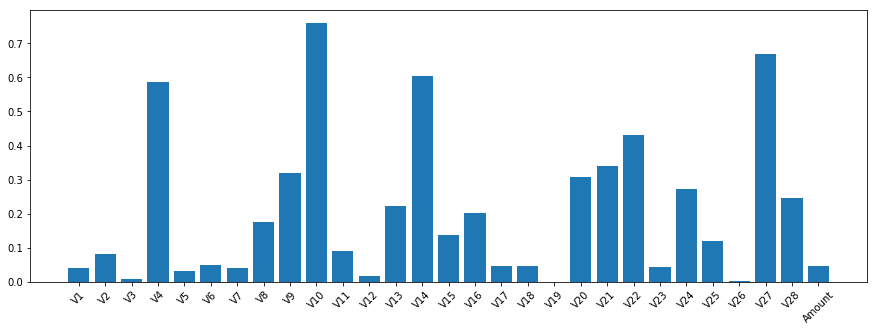

In [69]:
# plot coefficients
plt.figure(figsize=(15, 5))
plt.bar(train.drop("Class", axis=1).columns, abs(lr.coef_[0]))
plt.xticks(rotation=45)
plt.show()

The columns with the highest magnitude coefficients are
* V4
* V9
* V10 
* V13
* V14
* V20
* V21
* V22
* V24
* V27
* V28

### Finding Best Columns For Tree Based Classification

In [71]:
# Train a random forest model on the data
# and plot feature importances


# create model
rf = RandomForestClassifier()

# fit
rf.fit(X_train, y_train)

# predict
predictions_train = rf.predict(X_train)
predictions_val = rf.predict(X_val)

# print results
print(f"Training Scores: \n {classification_report(y_train, predictions_train)}")
print(f"Validation Scores: \n {classification_report(y_val, predictions_val)}")

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    216688
           1       1.00      0.97      0.99       362

    accuracy                           1.00    217050
   macro avg       1.00      0.99      0.99    217050
weighted avg       1.00      1.00      1.00    217050

Validation Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24077
           1       0.91      0.72      0.81        40

    accuracy                           1.00     24117
   macro avg       0.95      0.86      0.90     24117
weighted avg       1.00      1.00      1.00     24117



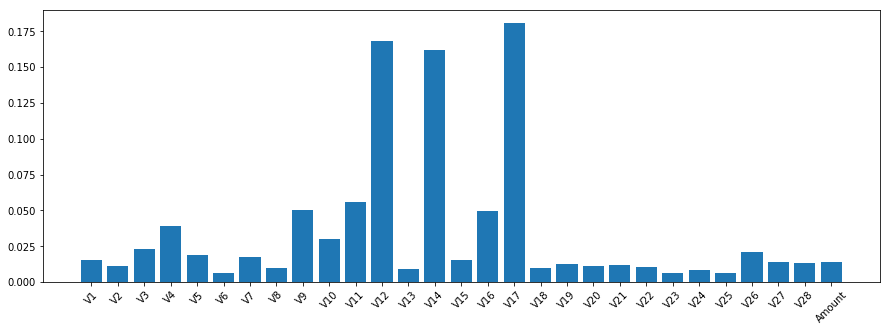

In [73]:
# plot feature importances
plt.figure(figsize=(15, 5))
plt.bar(train.drop("Class", axis=1).columns, abs(rf.feature_importances_))
plt.xticks(rotation=45)
plt.show()

It seems the best features for tree based algorithms are:
* V9
* V11
* V12
* V14
* V16
* V18 

Lets see if the f1-score of the classifier lowers if we only use these features.

In [7]:
# see if the f1-score of the random forest model
# increases if we only use certain features

# create a list of features to use
feats = ["V11", "V12", "V14", "V16", "V18"]

# seperate X and y variables
X, y = train[feats], train.Class

# train model
rf.fit(X, y)

# predict and print f1-score
print("F1 Score:", f1_score(y, rf.predict(X)))

NameError: name 'rf' is not defined

The score dropped, but only by a fraction of a percent. I think the information saved during the resampling process is worth it.

# 2. Resample Data

Having unbalanced data is bad for machine learning algorithms. It induces bias because the algorithms are updated for every row they are trained on and the updates for failure will be much more frequent then the updates for success whenever the model predicts a fraud. This ultimately will make the model perform sub-optimaly. Resampling the data will make it balanced. I will be using the "NearMiss" algorithm which will remove non-fraud data points until there are equal amounts of fraud and non-fraud transactions in the data. I will be making one set of data for linear models and another for tree based models. The NearMiss algorithm is distance based. It first finds the distance between each point. Then it finds the points that belong to the majority class that are, on average, the farthest distance away from the points in the manority class. It then removes those points from the majority class one-by-one until the two classes have the same amount of points. This means only the members of the majority class in the closest proximity to the minority class will be saved, thus saving the most information. Since NearMiss is a machine learning model and uses distance it is ussually a good idea to scale the data and remove any unneccesary features. This dataset is a product of PCA so I am assuming it is already scaled. Another important thing to note is that resampled data should never be used for testing, only for training. After the data is resampled it will better expose it to testing and finding multicolinearity. The data is extremely imbalanced, but the random forest still performs decently well. I will try resampling it to a 1:5 ratio instead of a 1:200 ratio in order to save as much information as possible.

In [20]:
# scale and resample data for linear models & tree based models

# create lists of features to use
linear_feats = ["V9", "V10", "V11", "V12", "V14", "V16", "V17", "V18"]
tree_feats = feats # see above


# create duplicates of fraud using random sampling to make
# it 40 times larger
# the data will end up with a 1:5 ratio of frauds and non frauds
# i will use random sampling for this
fraud = train[train.Class == 1]
upsampled_train = train
for i in range(10):
    sample = fraud.sample(frac=0.33)
    upsampled_train = pd.concat([upsampled_train, sample], axis=0)

# seperate X and y for both linear and tree data
lin = upsampled_train[linear_feats]
tree = upsampled_train[tree_feats]
y = upsampled_train["Class"]

# skip scaling



# instantiate NearMiss object
nm = NearMiss()

# fit the NearMiss object and resample the scaled data
lin_resampled_X, lin_resampled_y = nm.fit_resample(lin, y)
tree_resampled_X, tree_resampled_y = nm.fit_resample(tree, y)


# create function to put arrays back into dataframe format
def to_dataframe(X, y, feat_names):
    """Function takes in two arrays and column names then returns a dataframe
    X: a 2D array holding feature data
    y: a 1D array holding target data
    feat_names: A list of strings holding column names for X"""
    
    # create dataframes
    X_df = pd.DataFrame(X, columns=feat_names)
    y_df = pd.Series(y, name="Class")
    
    # concat and return
    return pd.concat([X_df, y_df], axis=1)


# place resampled data back into a dataframe
lin_resampled = to_dataframe(lin_resampled_X, lin_resampled_y, linear_feats)
tree_resampled = to_dataframe(tree_resampled_X, tree_resampled_y, tree_feats)

# drop duplicates
lin_resampled = lin_resampled.drop_duplicates()
tree_resampled = tree_resampled.drop_duplicates()

# preview
print(lin_resampled.Class.value_counts(normalize=True))
print(tree_resampled.Class.value_counts(normalize=True))
lin_resampled.head()

0    0.809659
1    0.190341
Name: Class, dtype: float64
0    0.808023
1    0.191977
Name: Class, dtype: float64


,V9,V10,V11,V12,V14,V16,V17,V18,Class
0,-0.130495,0.251334,1.326568,-0.366401,-1.811128,1.845579,1.198149,0.045919,0
1,-0.127199,0.258039,1.359009,-0.306869,-1.799307,1.857997,1.189583,0.076910,0
2,-0.114641,0.268470,1.347001,-0.344255,-1.789682,1.858848,1.192985,0.081665,0
3,-0.126422,0.221884,1.348434,-0.340135,-1.767038,1.872040,1.195950,0.102157,0
4,-0.171270,0.168550,1.352489,-0.286154,-1.800278,1.861412,1.195286,0.063650,0


Now lets test the resampled data with a logistic regression model, and a random forest

In [28]:
# instantiate classifiers
lr = LogisticRegression()
rf = RandomForestClassifier()

# loop over classifiers
for clf, clf_name in zip([lr, rf], ["Logistic Regression", "Random Forest"]):
    # nested loop over different versions of the data
    for data_set, data_set_name in zip([lin_resampled, tree_resampled, train],
                                       ["linear resampled","tree resampled", "non-engineered"]):
        
        # seperate X and y
        X = data_set.drop("Class", axis=1)
        y = data_set.Class
        
        # fit classifier
        clf.fit(X, y)
        
        # make predictions
        predictions = clf.predict(X)
        
        # display results
        print(f"Classifier {clf_name}")
        print(f"Dataset: {data_set_name}")
        print(f"Results \n {classification_report(y, predictions)}")
                                       

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier Logistic Regression
Dataset: linear resampled
Results 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1710
           1       0.97      0.84      0.90       402

    accuracy                           0.97      2112
   macro avg       0.97      0.92      0.94      2112
weighted avg       0.97      0.97      0.96      2112

Classifier Logistic Regression
Dataset: tree resampled
Results 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1692
           1       0.97      0.84      0.90       402

    accuracy                           0.96      2094
   macro avg       0.97      0.92      0.94      2094
weighted avg       0.96      0.96      0.96      2094

Classifier Logistic Regression
Dataset: non-engineered
Results 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    240765
           1       0.88      0.62      0

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier Random Forest
Dataset: non-engineered
Results 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    240765
           1       1.00      0.94      0.97       402

    accuracy                           1.00    241167
   macro avg       1.00      0.97      0.98    241167
weighted avg       1.00      1.00      1.00    241167



# 3. Dealing with multicolinearity

Now that the data has been resampled, I will be able to see which features, if any, suffer from multicolinearity. Multicolinearity is when two features have a linear relationship, i.e. if one goes up the other almost always goes up/down. Multicolinearity is a problem for linear models because linear models work by tuning a coefficient for each variable and having two near identical variables introduces a bit of bias. To find the multicolinearity I can calculate each dataframes Pearson's Correlation and plot these values in a heatmap.

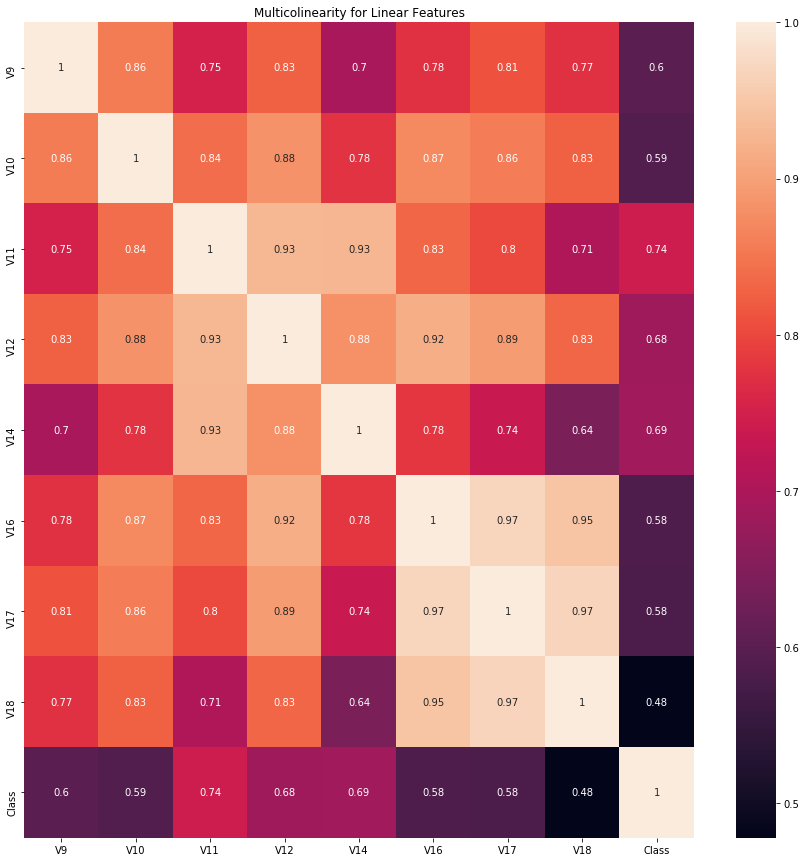

In [25]:
# find multicolinearity for linear data

# calculate correlations between variables
corr = abs(lin_df_rs.corr())

# plot data using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True)
plt.title("Multicolinearity for Linear Features")
plt.show()

Since the multicolinearity is so high, I will expiriment with Principal Component Analysis. PCA is an unsupervised learning technique which takes multiple features and morphs them into one, saving as much information as possible using Eigen-Vectors. Since there are three features not correlated with one another I will set the n_components parameter of the PCA model to 3. Meaning it will return a matrix with three columns.

In [26]:
# transform data with PCA

# instantiate PCA model
# set n_components to 3
pca = PCA(n_components=3)

# split X and y for linear resampled data
lin_rs_X = lin_df_rs.drop("Class", axis = 1)
lin_rs_y = lin_df_rs.Class

# fit and transform the linear resampled data
lin_rs_pca_X = pca.fit_transform(lin_rs_X)

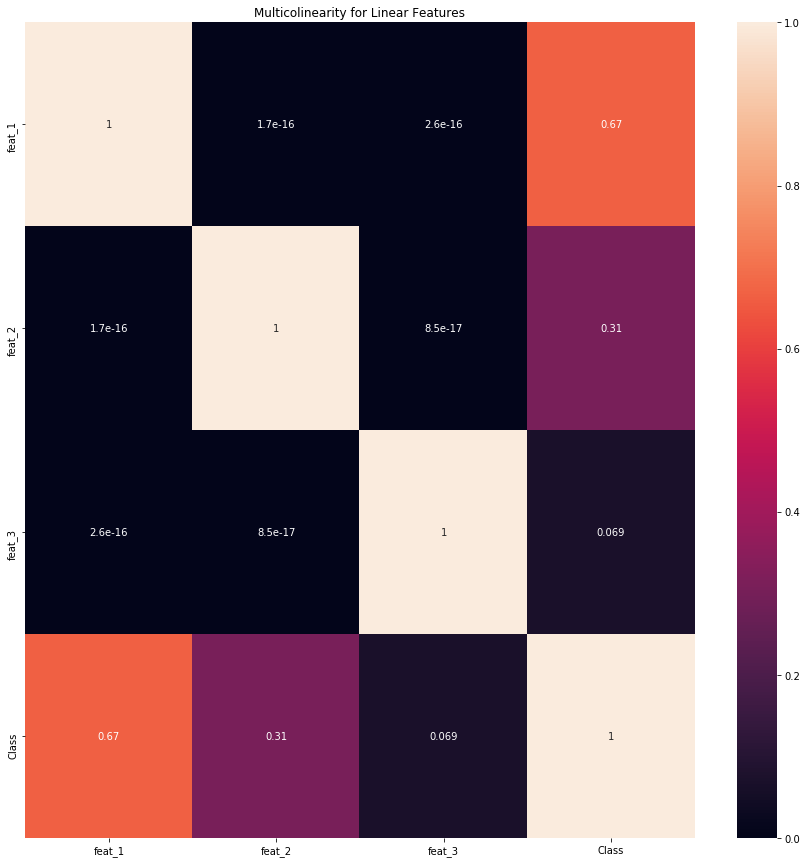

In [27]:
# fit data back into dataframe
lin_pca_df = to_dataframe(lin_rs_pca_X, lin_rs_y, ["feat_1", "feat_2", "feat_3"])

# re-examine multicolinearity

# calculate correlations between variables
corr = abs(lin_pca_df.corr())

# plot data using heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True)
plt.title("Multicolinearity for Linear Features")
plt.show()

# 4. Save Code For Automation

It seems the data has been well engineered. It is time to move on to the modeling stage. I have notes on what I have learned here that I need to save in a file I will call "feature_engineering_notes.pickle". 
* the linear features
* the tree features
* the n_components for PCA should be 3

In [104]:
# save the features lists in a dictionary 
# save that dictionary in a pickle file

# organize dictionary
feats = {
    "linear":linear_feats,
    "tree":tree_feats
}

# pickleing
out_file = feats
with open("feature_engineering_notes.pickle", "wb") as file_path:
    pickle.dump(feats, file_path)
    file_path.close()

Now I will save the code for engineering the data in a .py file called "custom_functions.py". This way it can all be prepared from function calls. Below is all the code that will be put into the file.

In [28]:
# functions I am going to save in a .py file called "custom_functions.py"

# function for seperating out desired features
def slice_feats(dataframe, feat_names):
    """This function takes in a dataframe and a list of the desired feature's names.
    It then slices those features out of the dataframe and returns the dataframes X and y values"""
    import pandas as pd
    
    sliced_dataframe = dataframe[feat_names + ["Class"]]
    
    return sliced_dataframe.drop("Class", axis=1), sliced_dataframe.Class
    
    
    

# Function for resampling
def resample_data(X, y):
    """This function takes in the X and y values for the training set.
    Then it resamples the data. Finally it returns the new
    X and y values"""
    
    from imblearn.under_sampling import NearMiss
    
    nm = NearMiss()
    
    return nm.fit_resample(X, y)

def slice_resample(dataframe, feat_names):
    """This function takes in a dataframe and a list of the desired feature's names. 
    It then slices the correct features out of the dataframe and splits it into X and y 
    variables. Then it resamples the data using the NearMiss algorithm. Finally it returns 
    the resampled data as X and y variables"""
    
    X, y = slice_feats(dataframe, feat_names)
    
    return resample_data(X, y)